In [101]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession \
    .builder \
    .appName("Around 500 cities in U.S. health condition") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

# Import Data
df = spark.read.csv("hdfs://namenode/data.csv", header=True, inferSchema=True)
# Preprocessing (remove duplicate data)
df.drop_duplicates() 
# Create Temporary Table
df.createOrReplaceTempView("health")
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- StateAbbr: string (nullable = true)
 |-- StateDesc: string (nullable = true)
 |-- CityName: string (nullable = true)
 |-- GeographicLevel: string (nullable = true)
 |-- DataSource: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- UniqueID: string (nullable = true)
 |-- Measure: string (nullable = true)
 |-- Data_Value_Unit: string (nullable = true)
 |-- DataValueTypeID: string (nullable = true)
 |-- Data_Value_Type: string (nullable = true)
 |-- Data_Value: double (nullable = true)
 |-- Low_Confidence_Limit: double (nullable = true)
 |-- High_Confidence_Limit: double (nullable = true)
 |-- Data_Value_Footnote_Symbol: string (nullable = true)
 |-- Data_Value_Footnote: string (nullable = true)
 |-- PopulationCount: integer (nullable = true)
 |-- GeoLocation: string (nullable = true)
 |-- CategoryID: string (nullable = true)
 |-- MeasureId: string (nullable = true)
 |-- CityFIPS: integer (nullable = true)
 |-- TractFIPS: 

In [32]:
# check cities number
df.groupby('Cityname').count().toPandas()

,Cityname,count
0,Tempe,1147
1,Corona,1036
2,Phoenix,10097
3,Compton,866
4,Anchorage,1596
...,...,...
470,Pawtucket,644
471,Provo,883
472,Sioux Falls,1145
473,Kenosha,838


<IPython.core.display.Javascript object>


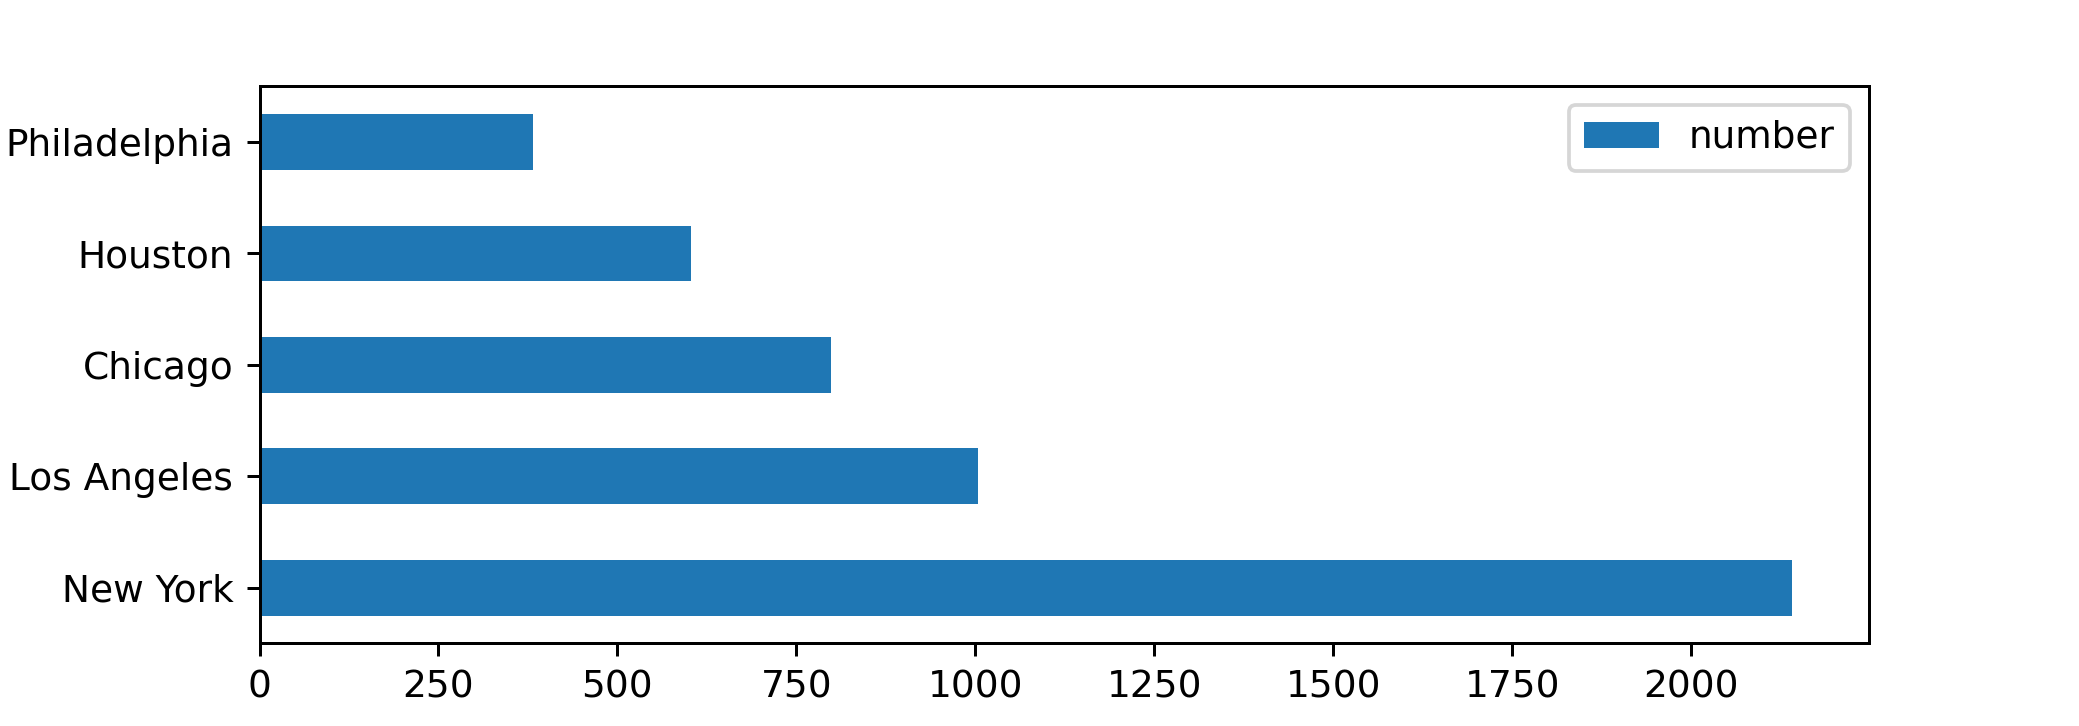

<AxesSubplot:ylabel='city_name'>

In [24]:
# Top five Number of people who has health outcomes surveyed in different states

results = spark.sql(" \
    select \
      count(distinct(UniqueID)) as number, \
      CityName as city_name \
        from health \
    group by CityName \
    order by number DESC LIMIT 5 \
                    ")

df_pandas = results.toPandas()
df_pandas.plot(kind='barh',x='city_name',y='number')

<IPython.core.display.Javascript object>


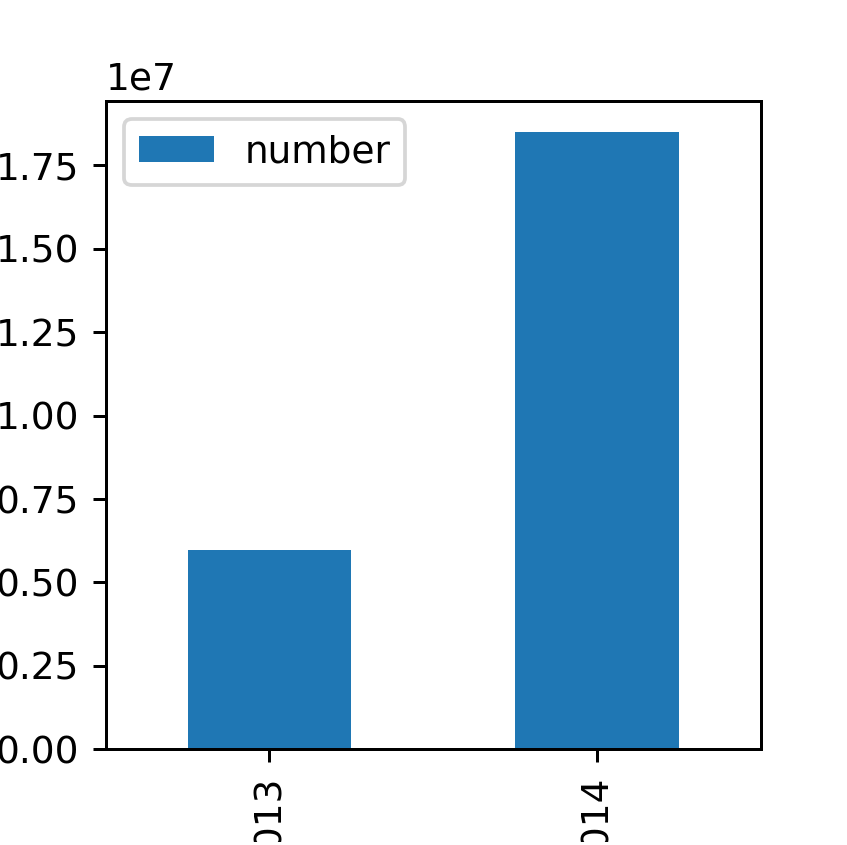

<AxesSubplot:xlabel='y'>

In [100]:
# Top five Number of people who has health outcomes surveyed in different states

results = spark.sql(" \
    select \
      Year as y, \
      sum(Data_Value) as number \
        from health \
    group by y \
    order by number \
                    ")

df_pandas = results.toPandas()
df_pandas.plot(kind='bar', x='y', y='number')

<IPython.core.display.Javascript object>


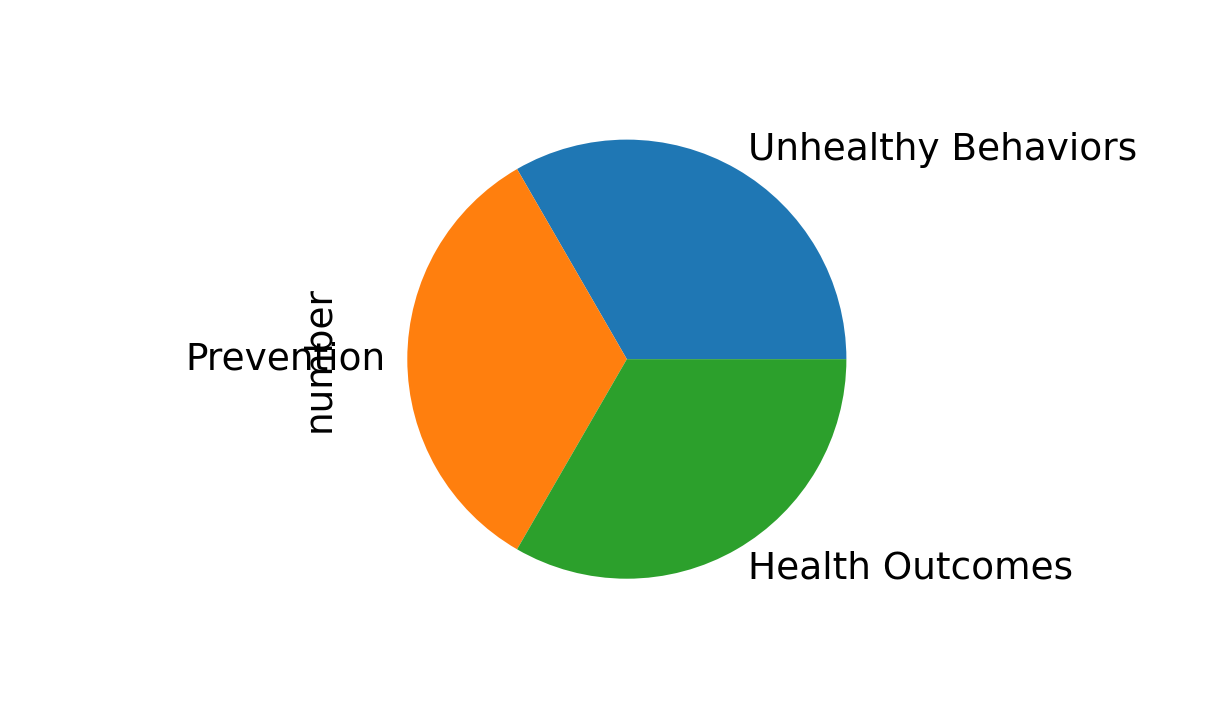

<AxesSubplot:ylabel='number'>

In [25]:
# Record for chronic disease risk factors, health outcomes, and clinical preventive services

results = spark.sql(" \
    select \
      count(distinct(UniqueID)) as number, \
      Category as c \
        from health \
    group by c \
    order by number \
                    ")

df_pandas = results.toPandas()
df_pandas.plot(kind='pie',y='number', labels=df_pandas['c'], legend = False)

In [71]:
from pyspark.ml.clustering import KMeans
# change Geo loation String type to double type, and seperate the latitude and longitude
Geo = spark.sql(" \
    select \
      DOUBLE(substring(GeoLocation, 2, \
      instr(GeoLocation, ',')-2)) as latitude, \
      DOUBLE(substring(GeoLocation, instr(GeoLocation, ',')+2, \
      length(GeoLocation)-instr(GeoLocation, ',')-2)) as longitude \
        from health \
                    ")

Geo.createOrReplaceTempView('location')
df = Geo.na.drop()
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = df.columns, outputCol = 'features')
final_df = assembler.transform(df)
# final_df.show(3)
kmeans = KMeans(featuresCol = 'features', k=5)
model = kmeans.fit(final_df)
# model.clusterCenters()
result = model.transform(final_df).select('latitude', 'longitude', 'prediction')
centroids = model.clusterCenters()
centroids

[array([  39.67559771, -125.23484421]),
 array([ 40.77099027, -75.70386417]),
 array([ 36.13089554, -93.83558612]),
 array([  35.05394968, -114.5819184 ]),
 array([ 34.22226279, -83.07385486])]

In [73]:
# Post-processing
l = []
for centroid in centroids:
    l.append((centroid[0],centroid[1]))
print(l)
k = 5
clusters = dict()
for i in range(k):
    clusters[i] = []
    
colors = ['b', 'k', 'r', 'm', 'y', 'c', 'c']
for row in result.rdd.collect():
    lat, lng, index = row
    clusters[int(index)].append((lat, lng))

centroid_colors = zip(l, colors)

[(39.67559770876362, -125.23484420946491), (40.77099026957997, -75.70386416716504), (36.13089553581142, -93.83558612031229), (35.05394968260581, -114.58191840414821), (34.2222627930633, -83.07385486142766)]


In [102]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(24,12))
map = Basemap(projection='mill',lon_0=20,resolution='c')
 
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='green',lake_color='aqua')

map.drawmapboundary(fill_color='aqua')
# draw lat/lon grid lines every 30 degrees.
map.drawmeridians(np.arange(0,360,30))
map.drawparallels(np.arange(-90,90,30))

# plot clusters
for centroid_idx in range(k):
    cluster = clusters[centroid_idx]
    num_samples = 1000
    if (len(cluster) > 1000):
        random_samples = random.sample(cluster, num_samples)
    else:
        random_samples = cluster
    for (lat, lon) in random_samples:
        x, y = map(lon, lat)
        color = colors[centroid_idx]
        marker_style = color + 'o'
        map.plot(x, y, marker_style, markersize=1.05)

# plot centroids
for (lat, lon), color in centroid_colors:
    x,y = map(lon, lat)
    marker_style = color + 'x'
    map.plot(x, y, marker_style, markersize=25, mew=5)

title_string = "Around 500 cities health problem"
plt.title(title_string)

plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'